In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts
from final.model_evaluation.classification_model_evaluation import train_classification_model
from final.model_evaluation.visualizations import visualize_model_feature_importances, visualize_2d_cluster_with_legend


In [3]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_c3_sz50000_1619216605.csv")
df.shape

(50000, 10)

# Encode C3

In [4]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='c3',drop_first=False)
encode_df.shape

(50000, 232)

In [5]:
encode_df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c1,c2,c3_a-line,...,c3_v-neck,c3_vest,"c3_vest, sleeveless",c3_video game,c3_video gaming merchandise,c3_wallets,c3_watches,c3_windbreaker,c3_women,c3_wrap
0,1201879,"Fire emblem, sacred stone, nintendo",3,Nintendo,24.0,1,Game plays great with no issues.,electronics,video games & consoles,0,...,0,0,0,0,0,0,0,0,0,0
1,1466980,Wet seal bathing suit,2,Wet Seal,7.0,1,Top is medium Bottom is xl,women,swimwear,0,...,0,0,0,0,0,0,0,0,0,0
2,763952,VSX Runner shorts,3,Victoria's Secret,13.0,1,Worn a couple times. No signs of wear. Size me...,women,athletic apparel,0,...,0,0,0,0,0,0,0,0,0,0
3,924139,Huge Lego Bundle,3,LEGO,129.0,0,"Huge bundle of Legos. 50+ figures, 2 bags neve...",kids,toys,0,...,0,0,0,0,0,0,0,0,0,0
4,932580,Polo Ralph Lauren polo shirt,3,Polo Ralph Lauren,20.0,0,Good condition Size large,men,tops,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 232 entries, train_id to c3_wrap
dtypes: float64(1), int64(3), object(5), uint8(223)
memory usage: 14.1+ MB


# Extract Item Name Features

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

progress-bar: 100%|██████████| 6250/6250 [01:22<00:00, 76.12it/s]

progress-bar: 100%|██████████| 6250/6250 [01:06<00:00, 94.60it/s] 

progress-bar: 100%|██████████| 6250/6250 [01:06<00:00, 94.20it/s] 


# Split Train Test

In [8]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [9]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 223 entries, c3_a-line to c3_wrap
dtypes: uint8(223)
memory usage: 10.6 MB


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, 
                                                    test_size=0.30, random_state=42, stratify = y)

# Vectorization of Item Name

In [11]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [12]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_test = np.concatenate((tv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)

In [13]:
names = tv.get_feature_names()
names

['and',
 'bag',
 'black',
 'bundle',
 'dress',
 'for',
 'jacket',
 'jeans',
 'lularoe',
 'men',
 'new',
 'nike',
 'nwt',
 'pink',
 'secret',
 'set',
 'size',
 'sweater',
 'victoria',
 'vs']

In [14]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)

# Classification - Random Forest

In [15]:
rf_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(RandomForestClassifier(n_estimators=50), 
                                                              X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.37434285714285714

Top 5 class with highest train accuracy
c3_sweater           - 0.77070
c3_panties           - 0.75000
c3_full zip          - 0.72785
c3_bras              - 0.69677
c3_military          - 0.68987

Top 5 class with lowest train accuracy
c3_breastfeeding     - 0.11392
c3_swings, jumpers & bouncers - 0.12821
c3_backpacks & carriers - 0.13376
c3_kitchen appliances - 0.15823
c3_hair styling tools - 0.15924
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.06393333333333333

Top 5 class with highest test accuracy
c3_sports            - 0.35294
c3_leggings          - 0.29851
c3_sweater           - 0.28358
c3_disposable diapers - 0.27941
c3_dress shirts      - 0.26866

Top 5 class with lowest test accuracy
c3_loafers & slip-ons - 0.00000
c3_blouse            - 0.00000
c3_doll              - 0.00000
c3_skirts, skorts & dresses - 0.00000
c3_sports & outdoor play - 0.00000


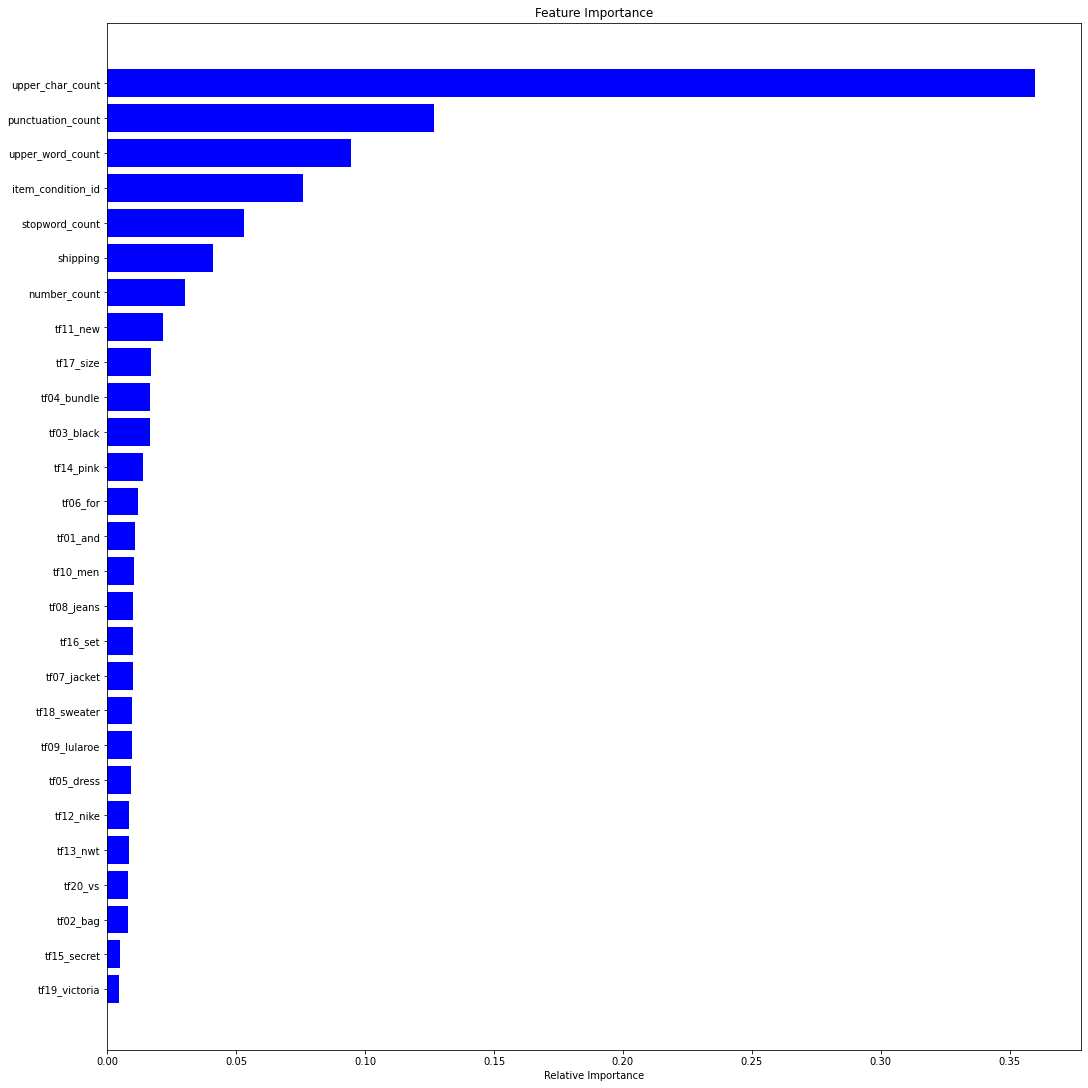

In [16]:
feature_importances = visualize_model_feature_importances(rf_model, x_tf_names, title = "Feature Importance")

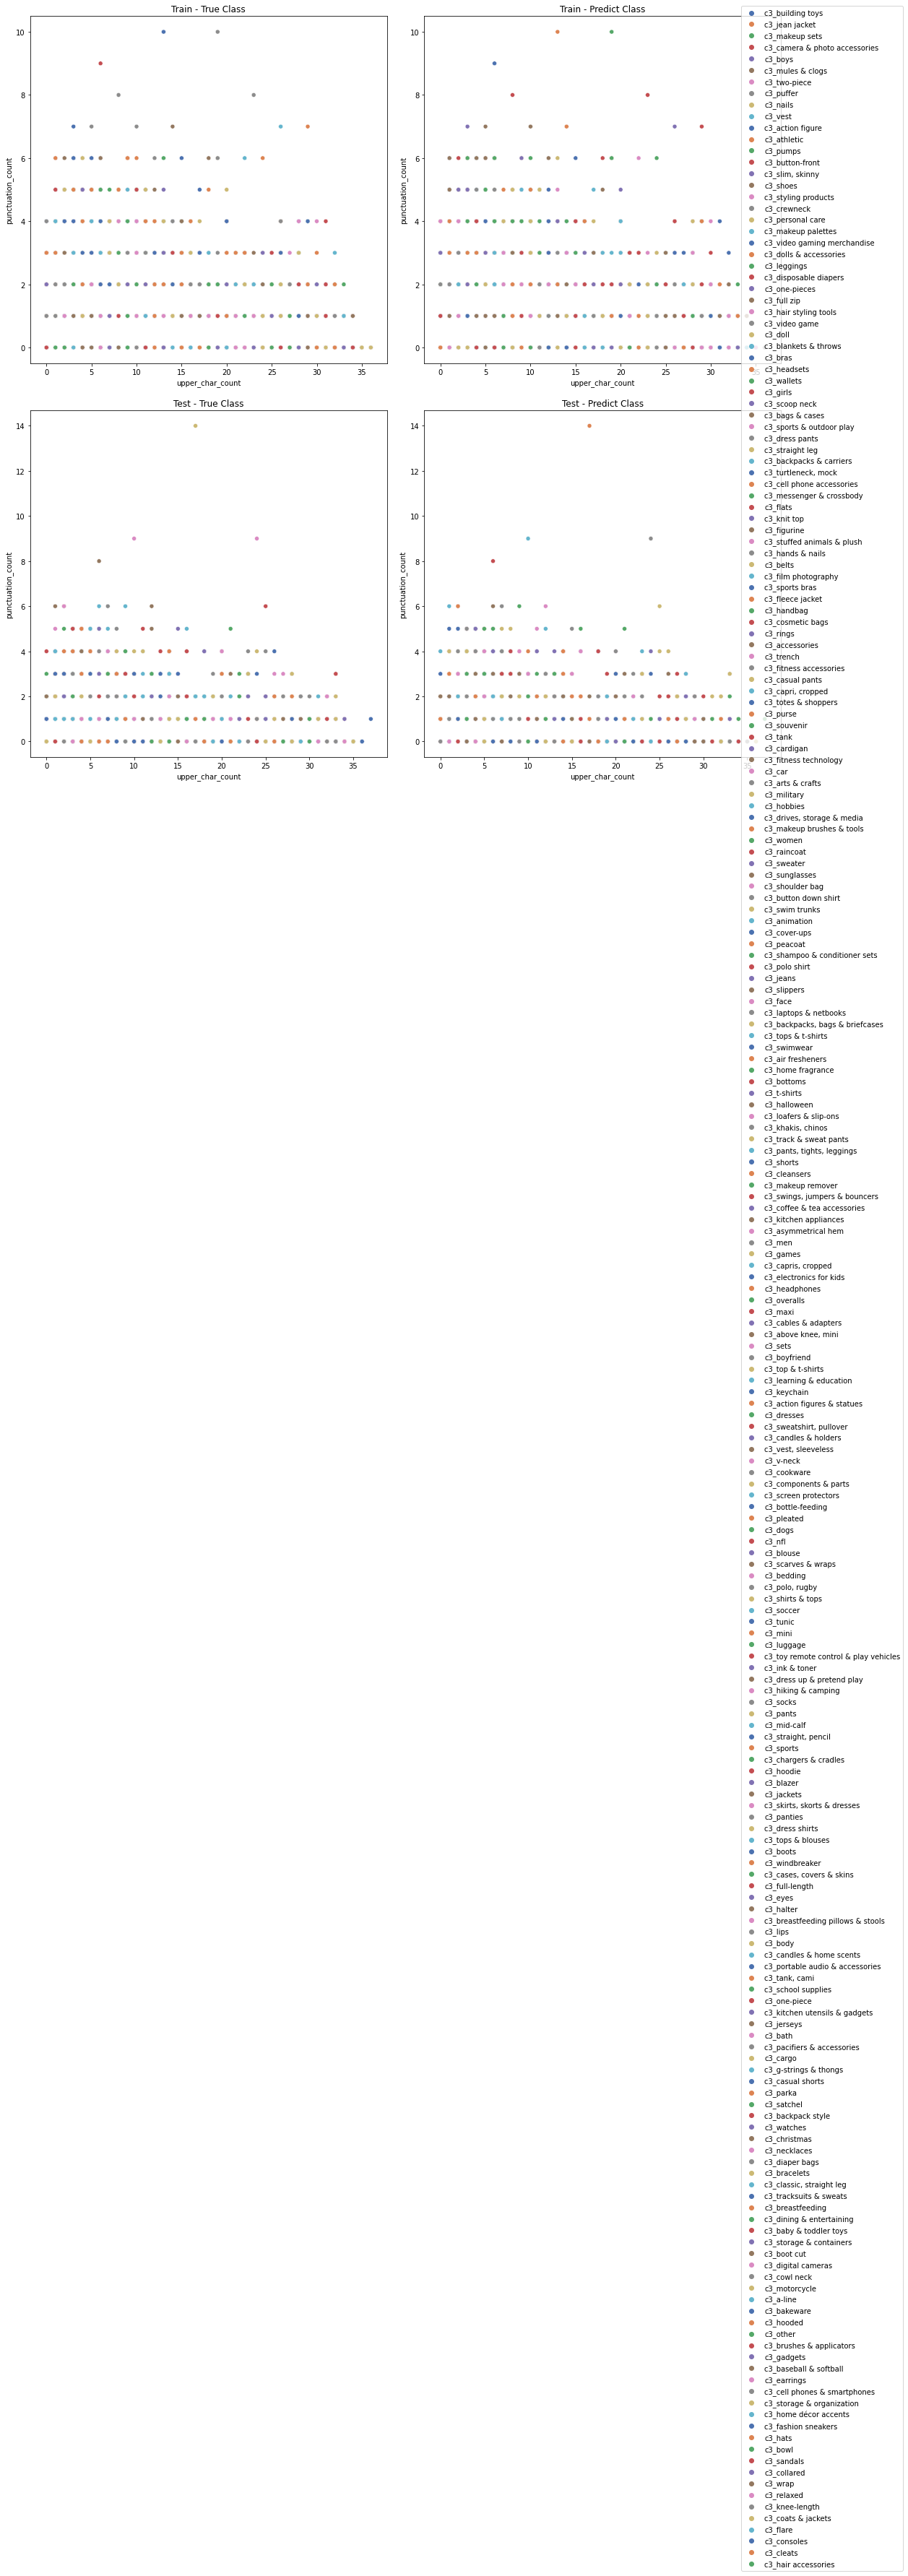

In [17]:
visualize_2d_cluster_with_legend('c3', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred)

# Classification - Logistic Regression

In [18]:
lr_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(LogisticRegression(max_iter=500), 
                                                             X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.0868

Top 5 class with highest train accuracy
c3_jean jacket       - 0.57325
c3_sweater           - 0.56051
c3_leggings          - 0.51899
c3_boyfriend         - 0.51282
c3_sets              - 0.51266

Top 5 class with lowest train accuracy
c3_halter            - 0.00000
c3_skirts, skorts & dresses - 0.00000
c3_hair styling tools - 0.00000
c3_hair accessories  - 0.00000
c3_learning & education - 0.00000
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.07853333333333333

Top 5 class with highest test accuracy
c3_sweater           - 0.50746
c3_screen protectors - 0.49254
c3_ink & toner       - 0.46970
c3_bowl              - 0.46269
c3_jean jacket       - 0.44776

Top 5 class with lowest test accuracy
c3_a-line            - 0.00000
c3_fitness accessories - 0.00000
c3_film photography  - 0.00000
c3_face              - 0.00000
c3_polo shirt        - 0.00000


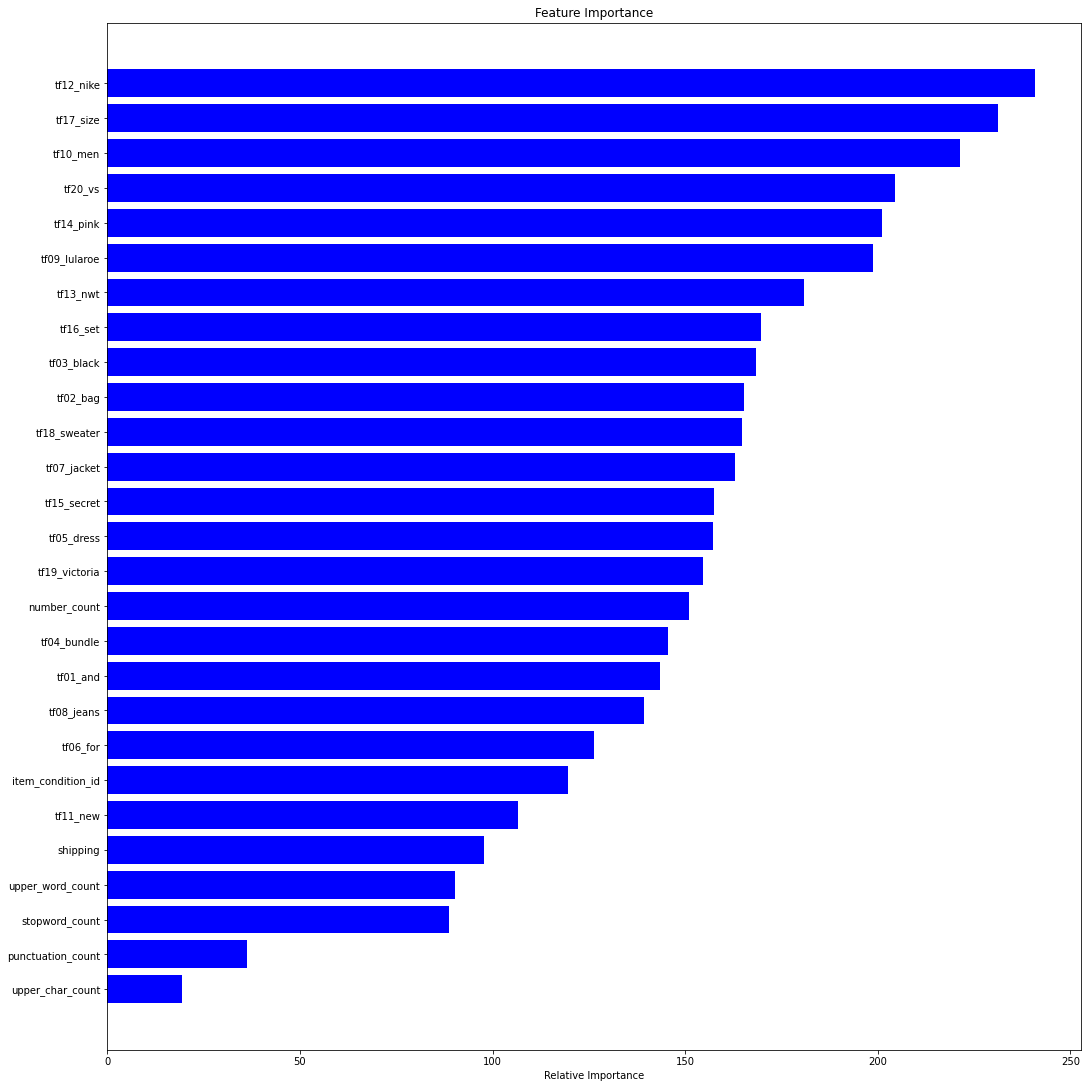

In [20]:
feature_importances = visualize_model_feature_importances(lr_model, x_tf_names, title = "Feature Importance")

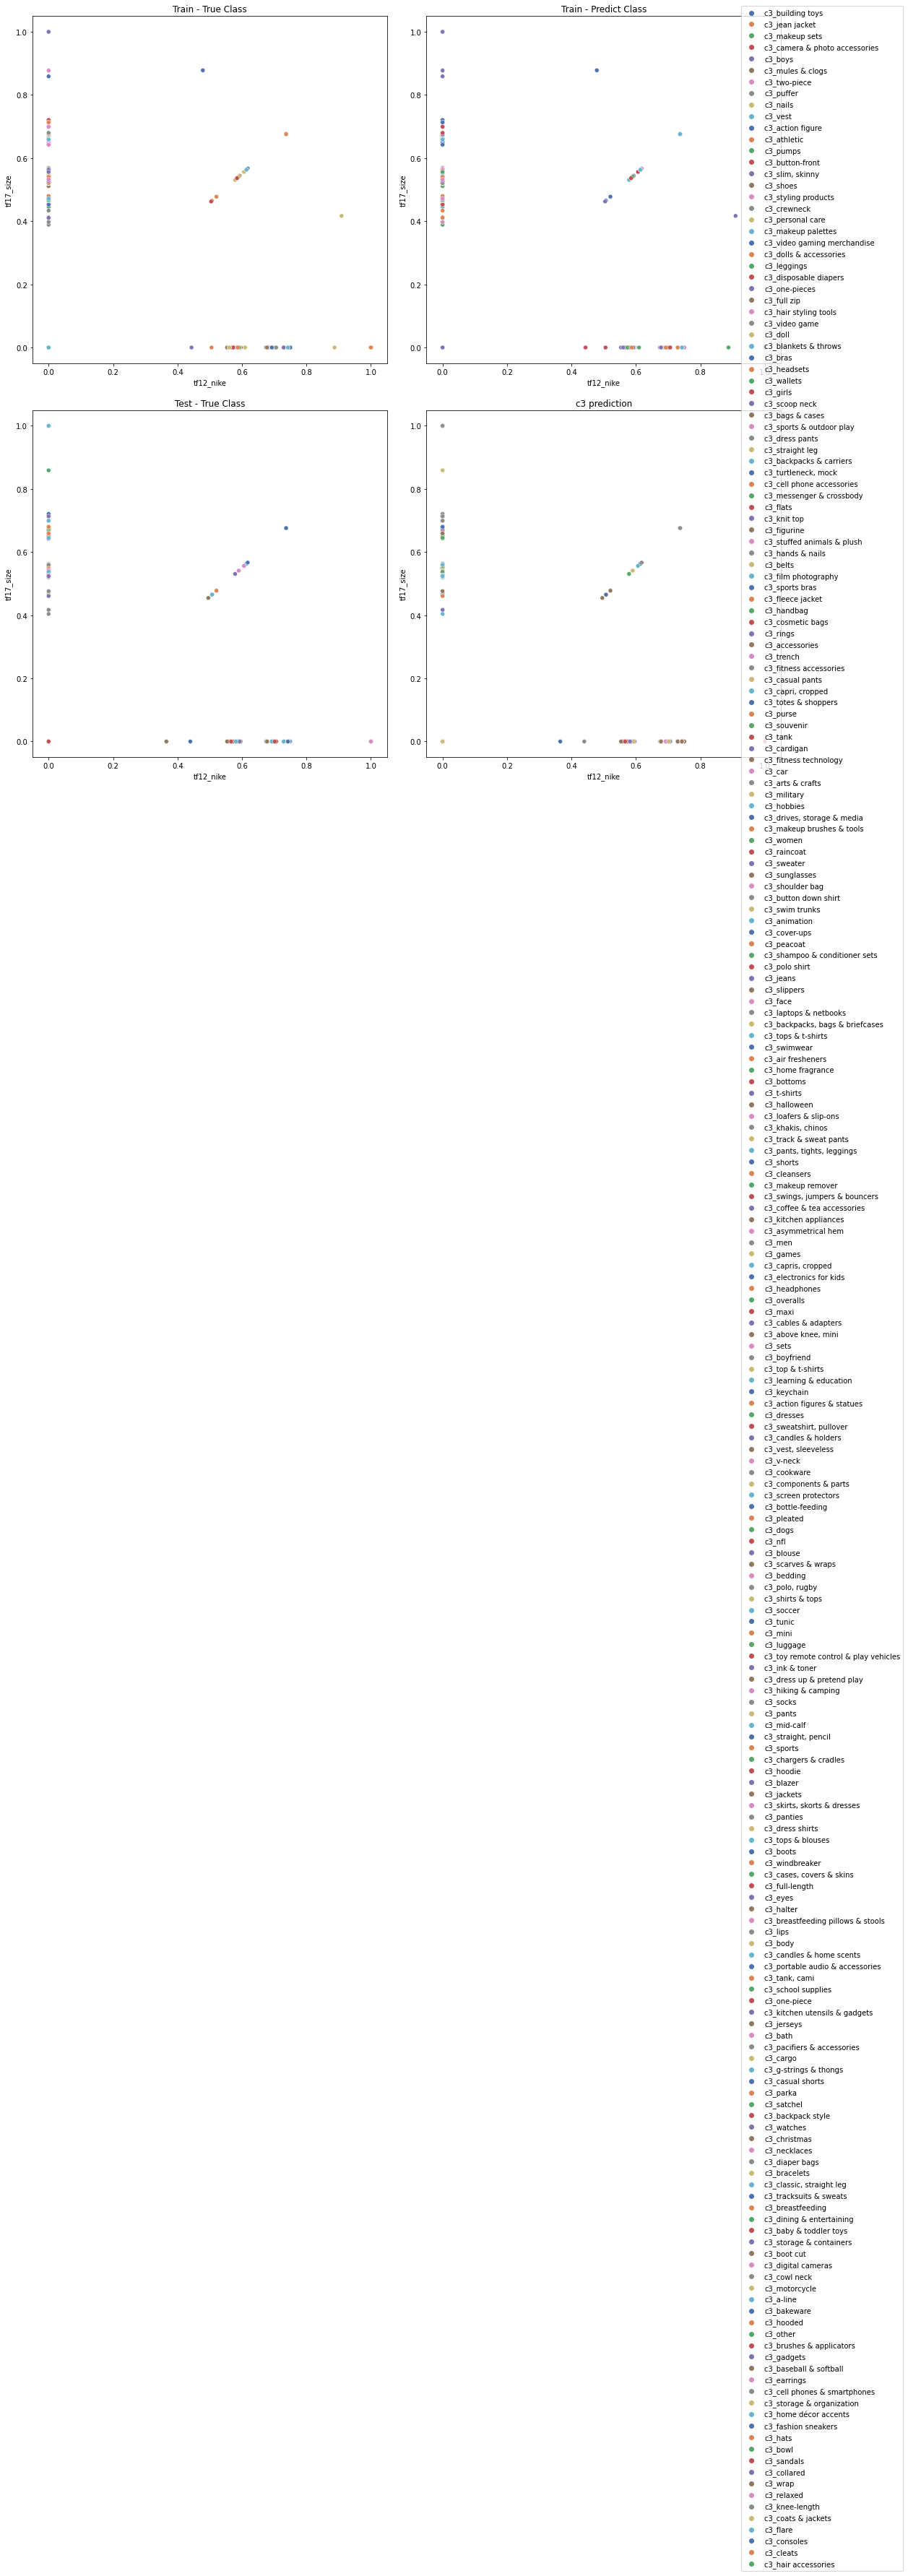

In [21]:
visualize_2d_cluster_with_legend('c3', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred,
                                legend = True, title = "c3 prediction")